# Target label definition

Describe the problem.

In [1]:
import pandas as pd
import os
import sys

# Append the path to access custom modules
if '../' not in sys.path:
    sys.path.append('../')

import src.modules.label_extraction as le
import src.modules.plotting as p
import importlib

from glob import glob

importlib.reload(le);
importlib.reload(p);

- `df_fsr`: contains freesurfers information
- `df_cdr`: contains data about subjects' visit from which it is possible to extract the target label

In [2]:
df_fsr = pd.read_csv('../data/csv/OASIS3_Freesurfer_output.csv')
df_cdr = pd.read_csv('../data/csv/OASIS3_UDSb4_cdr.csv')

- Remove from `df_fsr` the labels related to empty freesurfers

In [3]:
df_fsr = df_fsr[~df_fsr['MR_session'].isin(os.listdir('../data/empty'))]

- Define a new column in `df_cdr` and `df_fsr` that encapsule the temporal information

In [4]:
df_cdr['time'] = le.get_time_column(df_cdr['OASIS_session_label'])
df_fsr['time'] = le.get_time_column(df_fsr['MR_session'])

- Checking negative time columns for `df_cdr`:

In [5]:
df_cdr[df_cdr['time'] < 0].shape[0]

5

- Checking negative time columns for `df_fsr`:

In [6]:
df_fsr[df_fsr['time'] < 0].shape[0]

0

## Fixing negative time columns

- Clearly OAS30753 is a mistake: the cdr is null for this patient and we can't infer about its possible dementia
- The other ones looks like errors in typing, they will be fixed

In [7]:
df_cdr[df_cdr['time'] < 0]

,OASISID,OASIS_session_label,days_to_visit,age at visit,MMSE,memory,orient,judgment,commun,homehobb,...,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5,time
1883,OAS30290,OAS30290_UDSb4_d-0002,-2,47.45,NaN,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,No dementia,.,.,.,.,-2
2116,OAS30330,OAS30330_UDSb4_d-0101,-101,80.53,24.0,0.5,0.5,0.0,0.0,0.5,...,NaN,NaN,NaN,NaN,"DLBD, primary",.,.,.,.,-101
2462,OAS30380,OAS30380_UDSb4_d-0015,-15,61.39,28.0,0.5,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,uncertain dementia,Active Other neurol/med diagnoses,.,.,.,-15
4914,OAS30753,OAS30753_UDSb4_d-39520,-39520,-47.25,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39520
5667,OAS30851,OAS30851_UDSb4_d-0001,-1,73.49,NaN,0.5,0.0,0.5,0.5,0.5,...,NaN,NaN,NaN,NaN,"Non DAT, Other primary",.,.,.,.,-1


- Remove the error instance

In [8]:
df_cdr = df_cdr.drop(index=4914)
df_fsr = df_fsr.drop(index=df_fsr[df_fsr['Subject'] == 'OAS30753'].index)

- Fix the column and subject label names

In [9]:
df_cdr[['OASIS_session_label', 'time']] = le.fix_negative_time_label(df_cdr, 'time', 'OASIS_session_label')

## Align CDR

In [10]:
df_cdr['CDRTOT'] = le.align_labels(df_cdr, 'OASISID', 'CDRTOT')

OAS30007
OAS30013
OAS30035
OAS30040
OAS30051
OAS30052
OAS30058
OAS30064
OAS30070
OAS30071
OAS30072
OAS30084
OAS30091
OAS30101
OAS30104
OAS30108
OAS30117
OAS30118
OAS30119
OAS30123
OAS30132
OAS30133
OAS30136
OAS30139
OAS30145
OAS30151
OAS30153
OAS30161
OAS30165
OAS30171
OAS30173
OAS30179
OAS30181
OAS30185
OAS30194
OAS30203
OAS30206
OAS30207
OAS30208
OAS30212
OAS30218
OAS30223
OAS30224
OAS30233
OAS30237
OAS30240
OAS30241
OAS30250
OAS30257
OAS30259
OAS30261
OAS30263
OAS30279
OAS30292
OAS30305
OAS30314
OAS30322
OAS30323
OAS30329
OAS30342
OAS30343
OAS30347
OAS30354
OAS30355
OAS30369
OAS30375
OAS30377
OAS30380
OAS30396
OAS30404
OAS30415
OAS30418
OAS30421
OAS30428
OAS30433
OAS30445
OAS30448
OAS30451
OAS30452
OAS30463
OAS30466
OAS30467
OAS30475
OAS30479
OAS30481
OAS30498
OAS30505
OAS30515
OAS30528
OAS30533
OAS30536
OAS30553
OAS30560
OAS30563
OAS30565
OAS30572
OAS30593
OAS30596
OAS30597
OAS30605
OAS30608
OAS30612
OAS30614
OAS30619
OAS30627
OAS30665
OAS30667
OAS30669
OAS30675
OAS30692
OAS30700
O

## Target mapping

In this section we extract some target columns from `df_cdr`, that needs to be correctly mapped inside `df_fsr` for each different subject, using the time periods extracted in the previous python cell.

- The first target it's the CDR column from `df_cdr`

In [11]:
df_fsr['CDR'] = le.get_mapped_target_column(
    df_cdr.rename(columns={'OASISID': 'Subject'}), 
    df_fsr, 
    'Subject',
    target_col_name='CDRTOT'
)

## Checking the alignment

- This function detect and corrects situation in which the CDR for a certain subject is not monotonically increasing due to errors in the dataset

In [13]:
df_fsr['CDR'] = le.align_labels(df_fsr, 'Subject', 'CDR')

In [12]:
df_fsr['label'] = df_fsr['CDR'].map(lambda x: 'Cognitevely-normal' if x == 0 else 'MCI' if x == .5 else 'Demented')

- Label's distribution

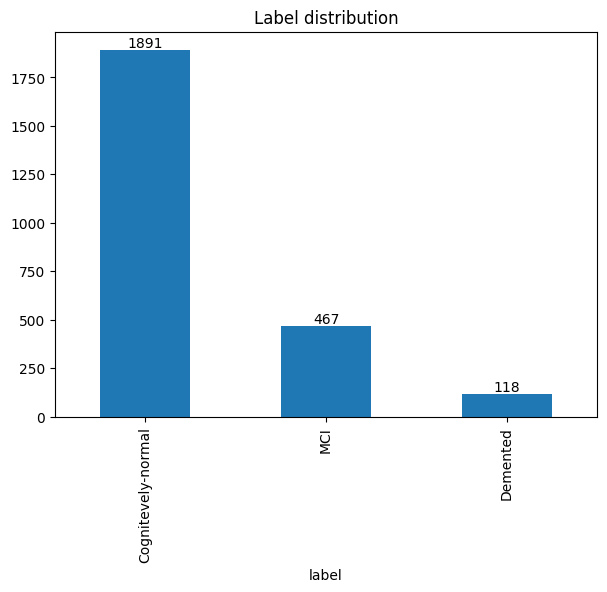

In [13]:
p.bar_plot(df_fsr['label'].value_counts(), 'Label distribution');

- Perform a final check

In [16]:
f = os.path.join('..', 'data', 'freesurfers')

left_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Left-Hippocampus.mgz')))
right_hippo_files = sorted(glob(os.path.join(f, '*', 'mri', '*Right-Hippocampus.mgz')))

l1 = [s.split("\\")[3] for s in left_hippo_files]
l2 = [s.split("\\")[3] for s in right_hippo_files]

print(f"The number of elements NOT in common is: {set.difference(set(l1), set(l2))}")

The number of elements NOT in common is: set()


- Get the final dataset as a csv

In [17]:
# Get rid of "noisy" patients aka patients not downloaded but present
# in the diagnosis csv
df_fsr.drop(index=df_fsr[~df_fsr['MR_session'].isin(l1)].index, inplace=True)

In [18]:
df_fsr.shape

(2475, 207)

In [19]:
df_fsr[[
    'Subject', 'MR_session', 'TOTAL_HIPPOCAMPUS_VOLUME', 'Left-Hippocampus_volume', 
    'lh_parahippocampal_thickness', 'lh_parahippocampal_volume', 'rh_parahippocampal_volume',
    'rh_parahippocampal_thickness', 'Right-Hippocampus_volume', 'label', 'CDR',
]].to_csv('../data/csv/final_dataset.csv')

In [26]:
df = pd.read_csv('../data/csv/final_dataset.csv')
df2 = df_cdr[['OASISID', 'CDRTOT', 'dx1', 'time']]

In [27]:
df2['CDRTOT'].value_counts()

CDRTOT
0.0    5678
0.5    2203
1.0     569
2.0     156
3.0      19
Name: count, dtype: int64